In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from process import Data_process
import os

In [2]:
allinfo = pd.read_csv(r'dataset\allinfo.csv')


In [15]:
# 按frame列大小从小到大进行排序
df_sorted = allinfo.sort_values(by='frame')

# 保留每个following_id的前375行
df_top375 = df_sorted.groupby('following_id').head(375)
print(df_top375.columns)
# 提取除去front_id和follow_id的列
df_features = df_top375.drop(columns=['Unnamed: 0', 'front_id', 'following_id', 'frame', 'following_x', 'front_x','following_width','front_class',	
                                      'following_class','front_feature','following_feature'
], )

# 计算不同following_id的数量
num_following_ids = df_top375['following_id'].nunique()
df_features.columns

# 提取数据框的值，并转换为三维数组
data_array = df_features.values.reshape(num_following_ids,375,  -1)

# 输出三维数组的形状
print("三维数组的形状:", data_array.shape)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'distance', 'following_x', 'front_x',
       'frame', 'front_speed', 'front_a', 'following_speed', 'following_a',
       'front_id', 'following_id', 'front_width', 'following_width',
       'front_class', 'following_class', 'front_feature', 'following_feature',
       'deltaspeed', 'deltaa'],
      dtype='object')
三维数组的形状: (290, 375, 9)


In [23]:
loss_array=[]
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans

class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Return the final hidden state
        return out[:, -1, :]


class LSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hx, cx):
        # Forward propagate LSTM
        out, _ = self.lstm(x, (hx, cx))

        # Decode the hidden state to the output space
        out = self.fc(out)

        return out


# Convert data to PyTorch tensor
data_tensor = torch.tensor(data_array, dtype=torch.float32)

# Normalize data
data_mean = torch.mean(data_tensor, dim=(0, 1), keepdim=True)
data_std = torch.std(data_tensor, dim=(0, 1), keepdim=True)
data_tensor = (data_tensor - data_mean) / data_std

# Define model parameters
input_size = 9
hidden_size = 100
output_size = 9
num_layers = 1

# Initialize encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(input_size, hidden_size, output_size, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)


# Training
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    encoded = encoder(data_tensor)
    # Get the last hidden state of the encoder as initial hidden state for decoder
    hx, cx = encoded.unsqueeze(0), torch.zeros_like(encoded).unsqueeze(0)
    decoded = decoder(data_tensor, hx, cx)
    
    # Compute loss
    loss = criterion(decoded, data_tensor)
    loss_array.append(loss.item())
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if loss < 0.05:
        break
# Get encoded representation of data
encoded_data = encoder(data_tensor).detach().numpy()

# Perform KMeans clustering on encoded data
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters as needed
kmeans.fit(encoded_data)

cluster_labels_lstm = kmeans.labels_



print("Cluster labels:", cluster_labels_lstm)

from sklearn.metrics import silhouette_score



# 计算轮廓系数
silhouette_coefficient = silhouette_score(encoded_data, cluster_labels_lstm)
print("Silhouette Coefficient:", silhouette_coefficient)

Epoch [10/1000], Loss: 0.9313
Epoch [20/1000], Loss: 0.8228
Epoch [30/1000], Loss: 0.7116
Epoch [40/1000], Loss: 0.5944
Epoch [50/1000], Loss: 0.4591
Epoch [60/1000], Loss: 0.3117
Epoch [70/1000], Loss: 0.1923
Epoch [80/1000], Loss: 0.1129
Epoch [90/1000], Loss: 0.0678


d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster labels: [0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 2 0 0 2
 2 0 0 0 2 2 0 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 0 2 2 0
 2 2 2 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 0 0 0 2 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 0 0 0 2 2 0 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0
 0 0 0 0 2 2 2 0 0 0 0 1 2 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 0]
Silhouette Coefficient: 0.43364102


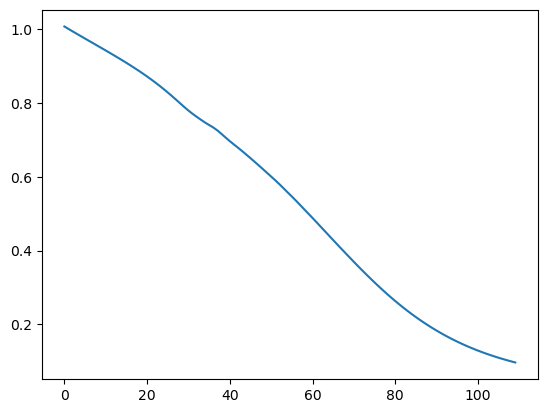

In [12]:
plt.plot(loss_array)

In [25]:
allinfo = pd.read_csv(r'dataset\allinfo.csv')
data = allinfo.sort_values(by='frame').groupby('following_id').mean()
data['feature'] = cluster_labels_lstm

cluster_means = data.groupby('feature').mean()
cluster_means

,Unnamed: 0.1,Unnamed: 0,distance,following_x,front_x,frame,front_speed,front_a,following_speed,following_a,front_id,front_width,following_width,front_class,following_class,front_feature,following_feature,deltaspeed,deltaa
feature,,,,,,,,,,,,,,,,,,,
0,200.484202,201.484202,40.600488,184.840544,225.441032,10194.854672,22.896304,4.449389,22.960279,4.623676,663.528817,11.203956,8.645272,0.630292,0.418899,NaN,NaN,-0.063975,-0.174287
1,196.392857,197.392857,42.102685,185.917548,228.020232,7008.250000,23.397408,4.318194,23.512288,4.673446,379.714286,10.112857,6.120714,0.500000,0.285714,NaN,NaN,-0.114881,-0.355252
2,199.238458,200.238458,40.620596,185.135576,225.756172,12027.198408,23.046948,4.486318,23.101727,4.662455,694.452100,10.749090,7.814505,0.571599,0.344715,NaN,NaN,-0.054779,-0.176137


In [26]:
data = data.reset_index(drop=False)
data = data[['front_id', 'following_id', 'feature']]
data.to_csv(r'dataset/aftercluster/datawithcluster_lstm.csv')